# Adding surface water to a model

*D.A. Brakenhoff, Artesia, 2020*
*R.J. Calje, Artesia, 2023*

This example notebook shows some how to add surface water defined in a GeoDataFrame to a MODFLOW model using the `nlmod` package.

There are three water boards in the model area, of which we download seasonal data about the stage of the surface water. In this notebook we perform a steady-state run, in which the stage of the surface water is the mean of the summer and winter stage. For locations without a stage from the water board, we delineate information from a Digital Terrain Model, to set a stage. We assign a stage of 0.0 m NAP to the river Lek. to The surface water bodies in each cell are aggregated using an area-weighted method and added to the model as a river-package.

In [1]:
import os

import flopy
import rioxarray
import matplotlib.pyplot as plt
import nlmod
from geocube.api.core import make_geocube
from functools import partial
from geocube.rasterize import rasterize_image

In [2]:
print(f"nlmod version: {nlmod.__version__}")

nlmod.util.get_color_logger("INFO")


nlmod version: 0.6.2b


<RootLogger root (INFO)>

## Load data

First we define the extent of our model and subsequently input that information into the convenient methods in `nlmod` to download all the relevant data and create a Modflow6 model.

In [3]:
model_name = "steady"
model_ws = "schoonhoven"
figdir, cachedir = nlmod.util.get_model_dirs(model_ws)
extent = [116_500, 120_000, 439_000, 442_000]

### AHN
Download the Digital Terrain model of the Netherlands (AHN). To speed up this notebook we download data on a resolution of 5 meter. We can change this to a resolution of 0.5 meter, changing the identifier to "AHN4_DTM_05m".

In [4]:
fname_ahn = os.path.join(cachedir, "ahn.tif")
if not os.path.isfile(fname_ahn):
    ahn = nlmod.read.ahn.get_ahn4(extent, identifier="AHN4_DTM_5m")
    ahn.rio.to_raster(fname_ahn)
ahn = rioxarray.open_rasterio(fname_ahn, mask_and_scale=True)

### Layer 'waterdeel' from bgt
As the source of the location of the surface water bodies we use the 'waterdeel' layer of the Basisregistratie Grootschalige Topografie (BGT). This data consists of detailed polygons, maintained by dutch government agencies (water boards, municipalities and Rijkswatrstaat).

In [5]:
bgt = nlmod.read.bgt.get_bgt(extent)

#### Add minimum surface height around surface water bodies
Get the minimum surface level in 5 meter around surface water levels and add these data to the column 'ahn_min'.

In [6]:
bgt = nlmod.gwf.add_min_ahn_to_gdf(bgt, ahn, buffer=5.0, column="ahn_min")

#### Plot 'bronhouder'
We can plot the column 'bronhouder' from the GeoDataFrame bgt. We see there are three water boards in this area (with codes starting with 'W').

<Axes: >

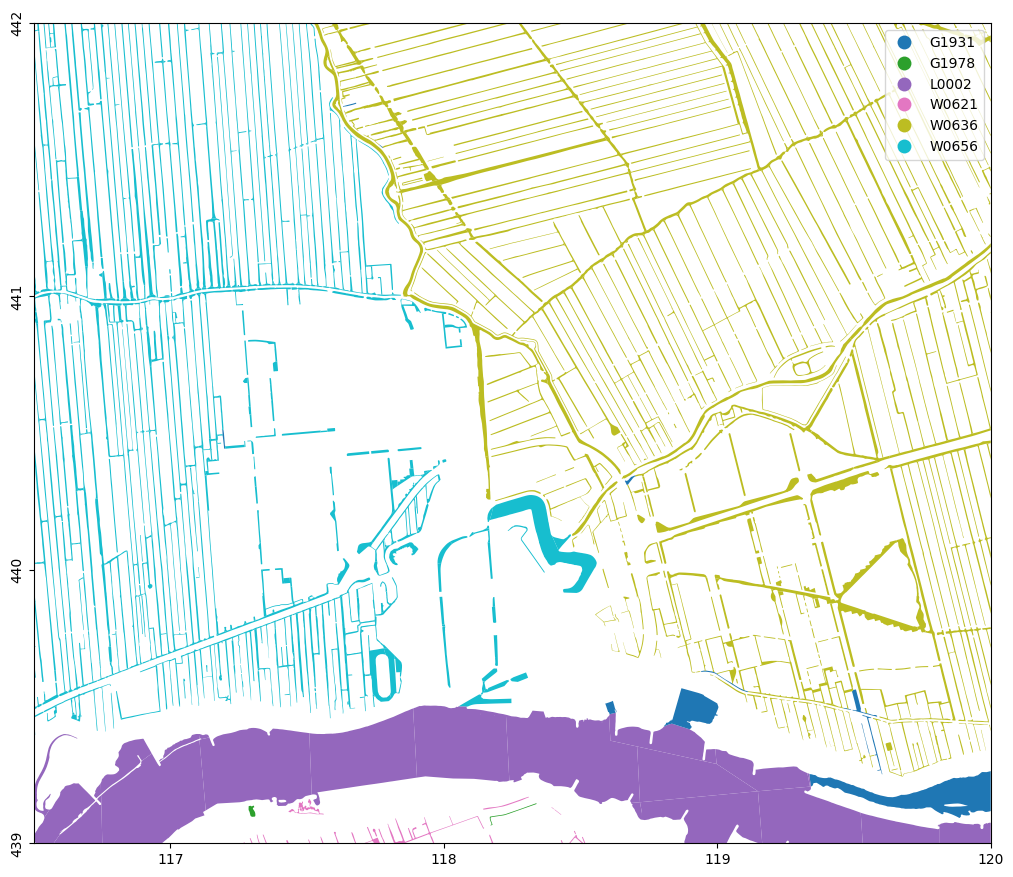

In [7]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot("bronhouder", legend=True, ax=ax)


### level areas
For these three waterboards we download the level areas (peilgebieden): polygons with information about winter and summer stages.

In [8]:
la = nlmod.gwf.surface_water.download_level_areas(
    bgt, extent=extent, raise_exceptions=False
)

INFO:nlmod.gwf.surface_water.download_level_areas:Downloading level_areas for De Stichtse Rijnlanden
INFO:nlmod.gwf.surface_water.download_level_areas:Downloading level_areas for Rivierenland
INFO:nlmod.gwf.surface_water.download_level_areas:Downloading level_areas for Schieland en de Krimpenerwaard


#### Plot summer stage
The method download_level_areas() generates a dictionary with the name of the water boards as keys and GeoDataFrames as values. Each GeoDataFrame contains the columns summer_stage and winter_stage. Let's plot the summer stage, together with the location of the surface water bodies.

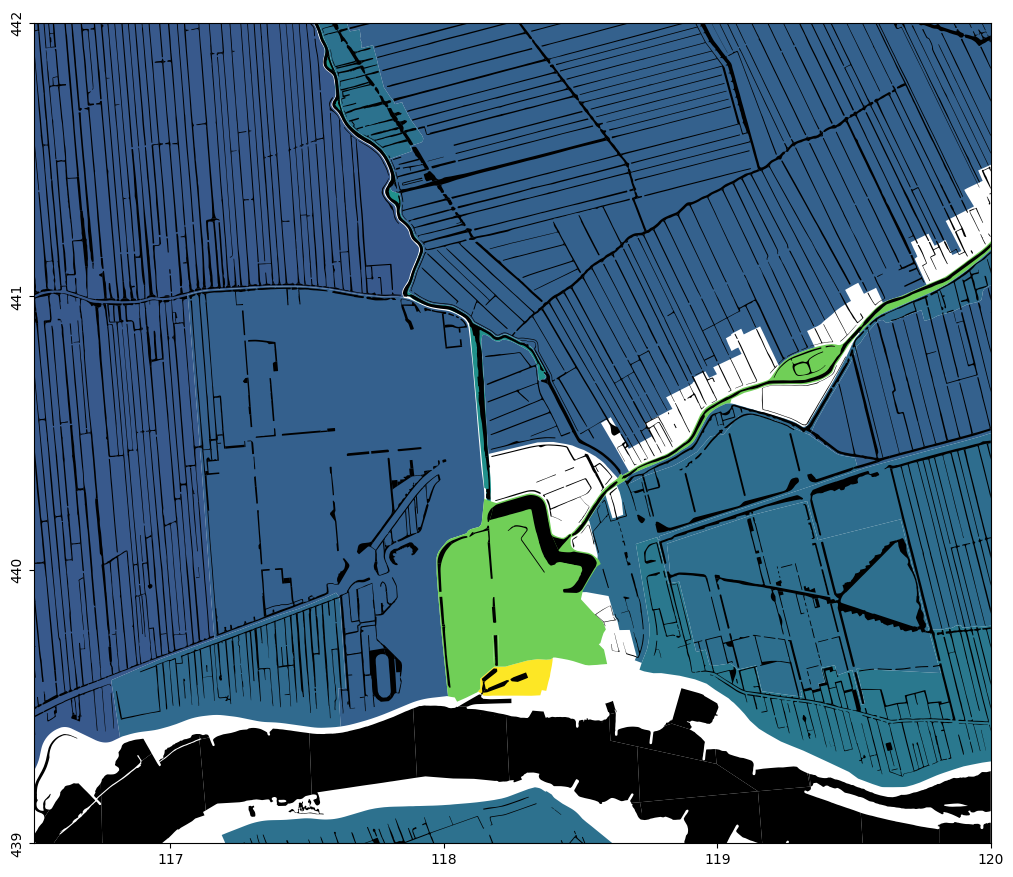

In [9]:
f, ax = nlmod.plot.get_map(extent)
bgt.plot(color="k", ax=ax)
for wb in la:
    la[wb].plot("summer_stage", ax=ax, vmin=-3, vmax=1, zorder=0)

#### Add stages to bgt-data
We then add the information from these level areas to the surface water bodies.

In [10]:
bgt = nlmod.gwf.surface_water.add_stages_from_waterboards(bgt, la=la)

Adding ['summer_stage', 'winter_stage'] from De Stichtse Rijnlanden: 100%|██████████| 533/533 [00:02<00:00, 229.84it/s]
Adding ['summer_stage', 'winter_stage'] from Rivierenland: 100%|██████████| 21/21 [00:00<00:00, 190.93it/s]
Adding ['summer_stage', 'winter_stage'] from Schieland en de Krimpenerwaard: 100%|██████████| 872/872 [00:03<00:00, 232.53it/s]


#### Save the data to use in other notebooks as well
We save the bgt-data to a geojson file, so we can use the data in other notebooks with surface water as well

In [11]:
fname_bgt = os.path.join(cachedir, "bgt.geojson")
bgt.to_file(fname_bgt, driver="GeoJSON")

#### Change some values in the GeoDataFrame for this model

In [12]:
sfw = bgt
sfw["stage"] = sfw[["winter_stage", "summer_stage"]].mean(1)
# use a water depth of 0.5 meter
sfw["botm"] = sfw["stage"] - 0.5
# set the stage of the Lek to 0.0 m NAP and the botm to -3 m NAP
mask = sfw["bronhouder"] == "L0002"
sfw.loc[mask, "stage"] = 0.0
sfw.loc[mask, "botm"] = -3.0

Take a look at the first few rows. For adding surface water features to a MODFLOW model the following attributes must be present:

- **stage**: the water level (in m NAP)
- **botm**: the bottom elevation (in m NAP)
- **c0**: the bottom resistance (in days)

The `stage` and the `botm` columns are present in our dataset. The bottom resistance `c0` is rarely known, and is usually estimated when building the model. We will add our estimate later on.

*__Note__: the NaN's in the dataset indicate that not all parameters are known for each feature. This is not necessarily a problem but this will mean some features will not be converted to model input.*

Now use `stage` as the column to color the data. Note the missing features caused by the fact that the stage is undefined (NaN).

<Axes: >

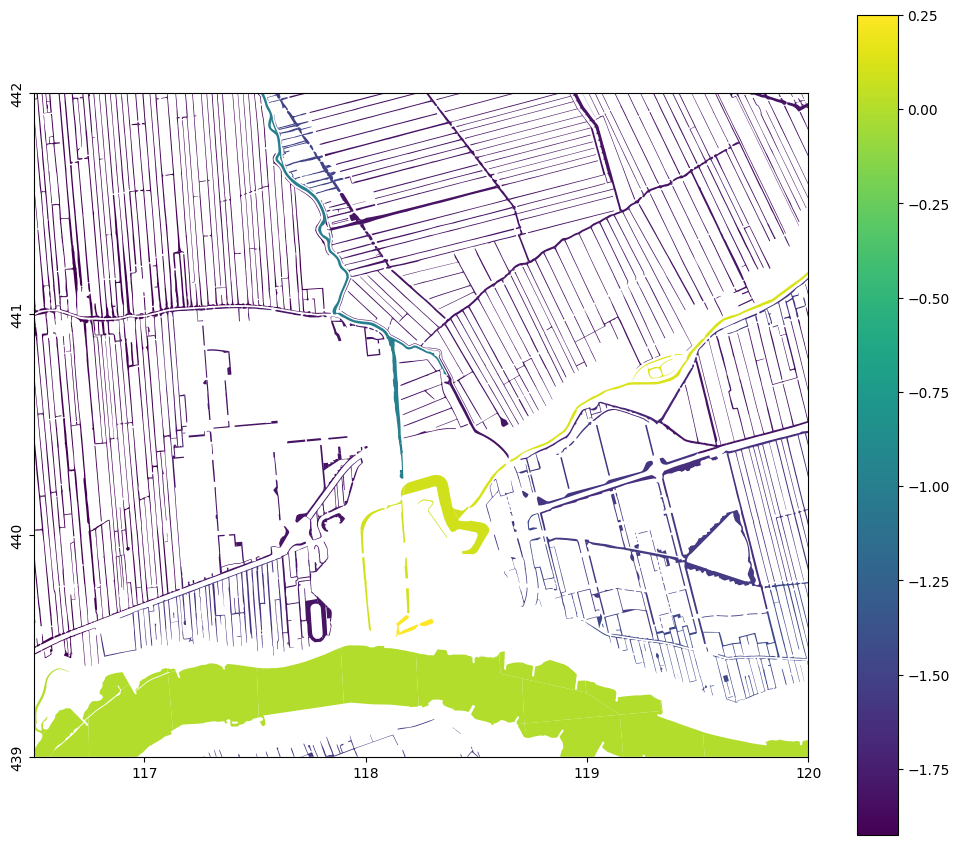

In [13]:
fig, ax = nlmod.plot.get_map(extent)
sfw.plot(ax=ax, column="stage", legend=True)

## Build model

The next step is to define a model grid and build a model (i.e. create a discretization and define flow parameters).

Build the model. We're keeping the model as simple as possible.

In [14]:
delr = delc = 50.0
start_time = "2021-01-01"

In [15]:
# layer model
layer_model = nlmod.read.get_regis(
    extent, cachedir=cachedir, cachename="layer_model.nc"
)
layer_model

INFO:nlmod.cache.decorator:caching data -> layer_model.nc


<xarray.Dataset>
Dimensions:  (layer: 29, y: 30, x: 35)
Coordinates:
  * x        (x) float64 1.166e+05 1.166e+05 1.168e+05 ... 1.198e+05 1.2e+05
  * y        (y) float64 4.42e+05 4.418e+05 4.418e+05 ... 4.392e+05 4.39e+05
  * layer    (layer) <U64 'HLc' 'KRWYk1' 'KRz2' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
Data variables:
    top      (layer, y, x) float32 ...
    botm     (layer, y, x) float32 -12.26 -12.11 -11.93 ... -592.3 -593.9 -595.5
    kh       (layer, y, x) float32 ...
    kv       (layer, y, x) float32 ...
Attributes: (12/40)
    references:                    https://www.dinoloket.nl/regis-ii-het-hydr...
    Conventions:                   CF-1.7
    creator_url:                   https://www.dinoloket.nl
    keywords_vocabulary:           NASA/GCMD Earth Science Keywords. Version 6.0
    acknowledgment:                https://www.dinoloket.nl
    project:                       REGIS v02r2
    ...                            ...
    geospatial_lon_resolution:     0.0014573401
    geospatial_vertical_min:       -1235.92
    geospatial_vertical_max:       322.75
    geospatial_vertical_units:     m-NAP
    geospatial_vertical_positive:  up
    extent:                        [116500, 120000, 439000, 442000]

In [16]:
# create a model ds by changing grid of layer_model
ds = nlmod.to_model_ds(layer_model, model_name, model_ws, delr=delr, delc=delc)

# create model time dataset
ds = nlmod.time.set_ds_time(ds, start_time=start_time, steady_state=True)

ds

INFO:nlmod.dims.base.to_model_ds:resample layer model data to structured modelgrid
INFO:nlmod.dims.layers.get_kh_kv:kv and kh both undefined in layer HLc
INFO:nlmod.dims.layers._fill_var:Filling 30376 values in active cells of kh by multipying kv with an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 67048 values in active cells of kv by dividing kh by an anisotropy of 10
INFO:nlmod.dims.layers._fill_var:Filling 4200 values in active cells of kh with a value of 1.0 m/day
INFO:nlmod.dims.layers._fill_var:Filling 4200 values in active cells of kv with a value of 0.1 m/day


<xarray.Dataset>
Dimensions:  (y: 60, x: 70, layer: 29, time: 1)
Coordinates:
  * layer    (layer) <U64 'HLc' 'KRWYk1' 'KRz2' 'KRz3' ... 'OOz2' 'OOc' 'BRk1'
  * x        (x) float64 1.165e+05 1.166e+05 1.166e+05 ... 1.199e+05 1.2e+05
  * y        (y) float64 4.42e+05 4.419e+05 4.419e+05 ... 4.391e+05 4.39e+05
  * time     (time) datetime64[ns] 2021-01-02
Data variables:
    top      (y, x) float32 -1.28 -1.28 -1.22 -1.22 ... -3.76 -3.76 -4.21 -4.21
    botm     (layer, y, x) float32 -12.26 -12.26 -12.11 ... -593.9 -595.5 -595.5
    kh       (layer, y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 0.02 0.02 0.02 0.02
    kv       (layer, y, x) float32 0.1 0.1 0.1 0.1 ... 0.002 0.002 0.002 0.002
    area     (y, x) float64 2.5e+03 2.5e+03 2.5e+03 ... 2.5e+03 2.5e+03 2.5e+03
Attributes:
    extent:      [116500, 120000, 439000, 442000]
    gridtype:    structured
    delr:        50.0
    delc:        50.0
    model_name:  steady
    mfversion:   mf6
    created_on:  20230828_13:39:24
    exe_name:    C:\Users\tombb\Python scripts\nlmod\nlmod\bin\mf6.exe
    model_ws:    schoonhoven
    figdir:      schoonhoven\figure
    cachedir:    schoonhoven\cache
    transport:   0

In [17]:
# create simulation
sim = nlmod.sim.sim(ds)

# create time discretisation
tdis = nlmod.sim.tdis(ds, sim)

# create ims
ims = nlmod.sim.ims(sim)

# create groundwater flow model
gwf = nlmod.gwf.gwf(ds, sim)

# Create discretization
dis = nlmod.gwf.dis(ds, gwf)

# create node property flow
npf = nlmod.gwf.npf(ds, gwf)

# Create the initial conditions package
ic = nlmod.gwf.ic(ds, gwf, starting_head=1.0)

# Create the output control package
oc = nlmod.gwf.oc(ds, gwf)

INFO:nlmod.sim.sim.sim:creating mf6 SIM
INFO:nlmod.sim.sim.tdis:creating mf6 TDIS
INFO:nlmod.sim.sim.ims:creating mf6 IMS
INFO:nlmod.gwf.gwf.gwf:creating mf6 GWF
INFO:nlmod.gwf.gwf._dis:creating mf6 DIS
INFO:nlmod.gwf.gwf.npf:creating mf6 NPF
INFO:nlmod.gwf.gwf.ic:creating mf6 IC
INFO:nlmod.gwf.gwf.ic:adding 'starting_head' data array to ds
INFO:nlmod.gwf.gwf.oc:creating mf6 OC


## Add surface water

Now that we have a discretization (a grid, and layer tops and bottoms) we can start processing our surface water shapefile to add surface water features to our model. The method to add surface water starting from a shapefile is divided into the following steps:

1. Intersect surface water shape with grid. This steps intersects every feature with the grid so we can determine the surface water features in each cell.
2. Aggregate parameters per grid cell. Each feature within a cell has its own parameters. For MODFLOW it is often desirable to have one representative set of parameters per cell. These representative parameters are calculated in this step.
3. Build stress period data. The results from the previous step are converted to stress period data (generally a list of cellids and representative parameters: `[(cellid), parameters]`) which is used by MODFLOW and flopy to define boundary conditions.
4. Create the Modflow6 package

The steps are illustrated below.

### Intersect surface water shape with grid

The first step is to intersect the surface water shapefile with the grid.

In [18]:
sfw_grid = nlmod.grid.gdf_to_grid(sfw, gwf)

Intersecting with grid: 100%|██████████| 1466/1466 [00:12<00:00, 115.19it/s]


Plot the result and the model grid and color using `cellid`. It's perhaps a bit hard to see but each feature is cut by the gridlines. 

<Axes: >

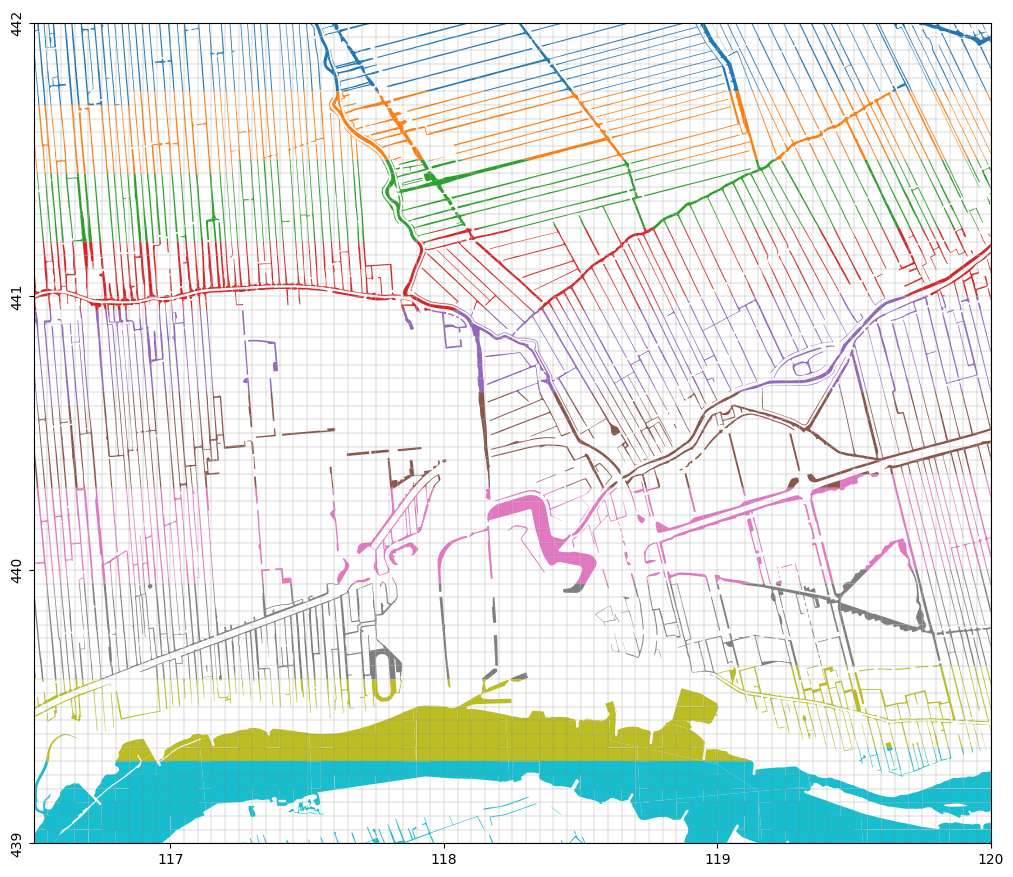

In [19]:
fig, ax = nlmod.plot.get_map(extent)
sfw_grid.plot(ax=ax, column="cellid")
nlmod.plot.modelgrid(ds, ax=ax, lw=0.2)

### Aggregate parameters per model cell
The next step is to aggregate the parameters for all the features in one grid cell to obtain one representative set of parameters. First, let's take a look at a grid cell containing multiple features. We take the gridcell that contains the most features.

In [20]:
cid = sfw_grid.cellid.value_counts().index[0]
mask = sfw_grid.cellid == cid
sfw_grid.loc[mask]

,id,creationDate,LV-publicatiedatum,relatieveHoogteligging,inOnderzoek,eindRegistratie,tijdstipRegistratie,identificatie,bronhouder,bgt-status,...,plus-type,geometrie2dWaterdeel,terminationDate,ahn_min,summer_stage,winter_stage,stage,botm,cellid,area
4675,b5a53b635-d396-a910-bd9c-46e8226ec4a4,2015-10-29,2016-07-06T15:37:15,0,false,NaN,2016-01-04T08:50:54.000,W0656.4176282b44574547bcede985db7fe5dd,W0656,bestaand,...,sloot,"POLYGON ((116883.486 440993.240, 116878.898 44...",NaN,-1.803157,-1.9,-1.95,-1.925,-2.425,"(20, 7)",39.950023
4692,bc1e73327-d135-b9e7-e13c-17b8c4083248,2015-10-29,2016-07-06T15:37:15,0,false,NaN,2016-01-04T08:50:54.000,W0656.83c13a62fcfe48c5b57875cf46dc75e9,W0656,bestaand,...,sloot,"POLYGON ((116873.440 440990.300, 116874.380 44...",NaN,NaN,-1.9,-1.95,-1.925,-2.425,"(20, 7)",156.916996
4752,b277c12a5-3966-6d28-3aed-f2dd400195d7,2015-10-29,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.0e6ce3ddf93549e9a27c61c74fc137cb,W0656,bestaand,...,sloot,"POLYGON ((116851.360 440985.970, 116851.490 44...",NaN,-1.149745,-1.9,-1.95,-1.925,-2.425,"(20, 7)",5.025221
4755,bf86d3648-d739-c6cd-27fa-37eff9c50db0,2015-10-29,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.24911c2cea0a424bb77f938f03018800,W0656,bestaand,...,sloot,"POLYGON ((116896.400 440988.150, 116894.520 44...",NaN,NaN,-1.9,-1.95,-1.925,-2.425,"(20, 7)",24.901125
4761,bf005c07a-c701-61c5-bb2f-4e279861ae3b,2015-10-29,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.6e2532bfd67347e3b8e8cb5bd5834936,W0656,bestaand,...,sloot,"POLYGON ((116883.486 440993.240, 116883.604 44...",NaN,-1.619307,-1.9,-1.95,-1.925,-2.425,"(20, 7)",65.424827
4764,bc9da9d09-dd92-11a5-0d43-1a2d2bb95237,2015-10-29,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.7d6b1009236c4e70987caa7aa892892c,W0656,bestaand,...,sloot,"POLYGON ((116888.490 440975.040, 116887.562 44...",NaN,NaN,-1.9,-1.95,-1.925,-2.425,"(20, 7)",87.909658
4773,be5f3176f-bdab-4958-3908-52dfc31cf0b6,2015-10-29,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.acc14ed2620d4629a0808a8fb560f8fd,W0656,bestaand,...,sloot,"POLYGON ((116900.000 440980.894, 116900.000 44...",NaN,NaN,-1.9,-1.95,-1.925,-2.425,"(20, 7)",35.290249
4778,b89dd3d14-6605-3507-61c7-91e2c24510a5,2015-10-29,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.d944ed2bef2240f29609e88bdcd84881,W0656,bestaand,...,sloot,"POLYGON ((116855.330 440994.530, 116855.000 44...",NaN,-1.728949,-1.9,-1.95,-1.925,-2.425,"(20, 7)",81.433112
4794,bfd6384e1-9c87-7300-1242-8ac4111813ed,2019-08-15,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.2d08146a0abe438c82a958dd8b40f974,W0656,bestaand,...,sloot,"POLYGON ((116891.950 440975.570, 116888.490 44...",NaN,NaN,-1.9,-1.95,-1.925,-2.425,"(20, 7)",6.963900
4804,b3c18517a-b046-66d5-c912-f6d5f9e438b4,2019-08-15,2019-08-16T18:44:11,0,false,NaN,2019-08-15T15:24:33.000,W0656.a9bbdecbcd924c1595e037118cbcbd9a,W0656,bestaand,...,sloot,"POLYGON ((116854.790 440983.780, 116854.790 44...",NaN,-1.186425,-1.9,-1.95,-1.925,-2.425,"(20, 7)",8.207950


We can also plot the features within that grid cell.

Text(0.5, 1.0, 'Surface water shapes in cell: (20, 7)')

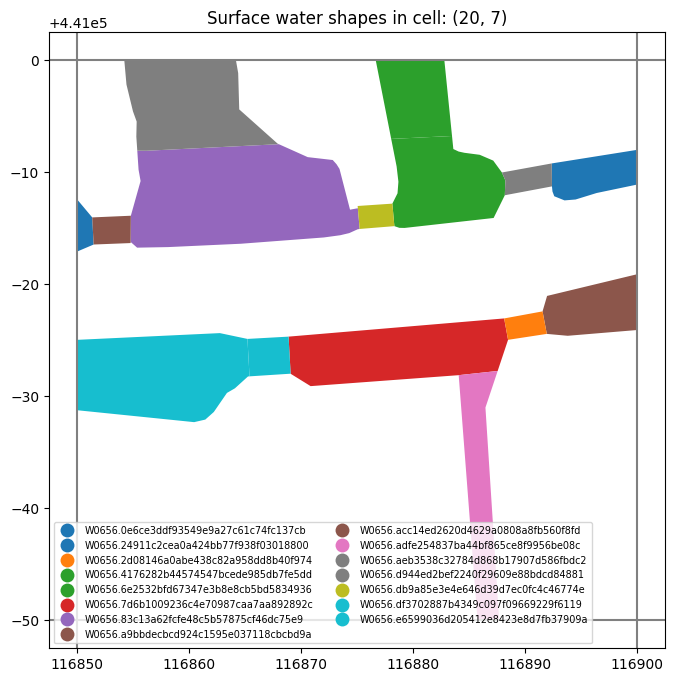

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sfw_grid.loc[mask].plot(
    column="identificatie",
    legend=True,
    ax=ax,
    legend_kwds={"loc": "lower left", "ncol": 2, "fontsize": "x-small"},
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
gwf.modelgrid.plot(ax=ax)
ax.set_xlim(xlim[0], xlim[0] + ds.delr * 1.1)
ax.set_ylim(ylim)
ax.set_title(f"Surface water shapes in cell: {cid}")


Now we want to aggregate the features in each cell to obtain a representative set of parameters (`stage`, `conductance`, `bottom elevation`) to use in the model. There are several aggregation methods. Note that the names of the methods are not representative of the aggregation applied to each parameter. For a full description see the following list:

- `'area_weighted'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is equal to area of surface water divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'max_area'`
  - **stage**: stage is determined by the largest surface water feature in a cell
  - **cond**: conductance is equal to area of all surface water features divided by bottom resistance
  - **elev**: the lowest bottom elevation is representative for the cell
- `'de_lange'`
  - **stage**: area-weighted average of stage in cell
  - **cond**: conductance is calculated using the formulas derived by De Lange (1999).
  - **elev**: the lowest bottom elevation is representative for the cell
  
Let's try using `area_weighted`. This means the stage is the area-weighted average of all the surface water features in a cell. The conductance is calculated by dividing the total area of surface water in a cell by the bottom resistance (`c0`). The representative bottom elevation is the lowest elevation present in the cell.

In [22]:
try:
    nlmod.gwf.surface_water.aggregate(sfw_grid, "area_weighted")
except ValueError as e:
    print(e)

Missing columns in DataFrame: {'c0'}


The function checks whether the requisite columns are defined in the DataFrame. We need to add a column containing the bottom resistance `c0`. Often a value of 1 day is used as an initial estimate.

In [23]:
sfw_grid["c0"] = 1.0  # days

Now aggregate the features.

In [24]:
celldata = nlmod.gwf.surface_water.aggregate(sfw_grid, "area_weighted")

Aggregate surface water data: 100%|██████████| 3551/3551 [00:19<00:00, 185.49it/s]


Let's take a look at the result. We now have a DataFrame with cell-id as the index and the three parameters we need for each cell `stage`, `cond` and `rbot`. The area is also given, but is not needed for the groundwater model. 

In [25]:
celldata.head(10)

stage        cond   rbot        area
0 0 -1.925  462.410341 -2.425  462.410341
  1 -1.925  459.780508 -2.425  459.780508
  2 -1.925  491.005144 -2.425  491.005144
  3 -1.925  415.290645 -2.425  415.290645
  4 -1.925  499.529157 -2.425  499.529157
  5 -1.925  412.999363 -2.425  412.999363
  6 -1.925  347.403279 -2.425  347.403279
  7 -1.925  333.055784 -2.425  333.055784
  8 -1.925  201.044358 -2.425  201.044358
  9 -1.925  427.468514 -2.425  427.468514

### Build stress period data

The next step is to take our cell-data and build convert it to 'stress period data' for MODFLOW. This is a data format that defines the parameters in each cell in the following format:

```
[[(cellid1), param1a, param1b, param1c],
 [(cellid2), param2a, param2b, param2c],
 ...]
```

The required parameters are defined by the MODFLOW-package used:

- **RIV**: for the river package `(stage, cond, rbot)`
- **DRN**: for the drain package `(stage, cond)`
- **GHB**: for the general-head-boundary package `(stage, cond)`

We're selecting the RIV package. We don't have a bottom (rbot) for each reach in celldata. Therefore we remove the reaches where rbot is nan (not a number).

In [26]:
new_celldata = celldata.loc[~celldata.rbot.isna()]
print(f"removed {len(celldata)-len(new_celldata)} reaches because rbot is nan")

removed 122 reaches because rbot is nan


In [27]:
riv_spd = nlmod.gwf.surface_water.build_spd(new_celldata, "RIV", ds)

Building stress period data RIV: 100%|██████████| 3429/3429 [00:00<00:00, 3731.94it/s]


Take a look at the stress period data for the river package:

In [28]:
riv_spd[:10]

[[(0, 0, 0), -1.9249999999999996, 462.4103410114336, -2.425],
 [(0, 0, 1), -1.9249999999999994, 459.780507649758, -2.425],
 [(0, 0, 2), -1.9249999999999998, 491.00514351109155, -2.425],
 [(0, 0, 3), -1.9249999999999998, 415.29064541268684, -2.425],
 [(0, 0, 4), -1.9249999999999998, 499.52915726560855, -2.425],
 [(0, 0, 5), -1.9249999999999998, 412.99936270143803, -2.425],
 [(0, 0, 6), -1.925, 347.4032788950671, -2.425],
 [(0, 0, 7), -1.9249999999999994, 333.05578372039884, -2.425],
 [(0, 0, 8), -1.925, 201.04435784327512, -2.425],
 [(0, 0, 9), -1.925, 427.4685140175443, -2.425]]

### Create RIV package
The final step is to create the river package using flopy.

In [29]:
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=riv_spd)

Plot the river boundary condition to see where rivers were added in the model

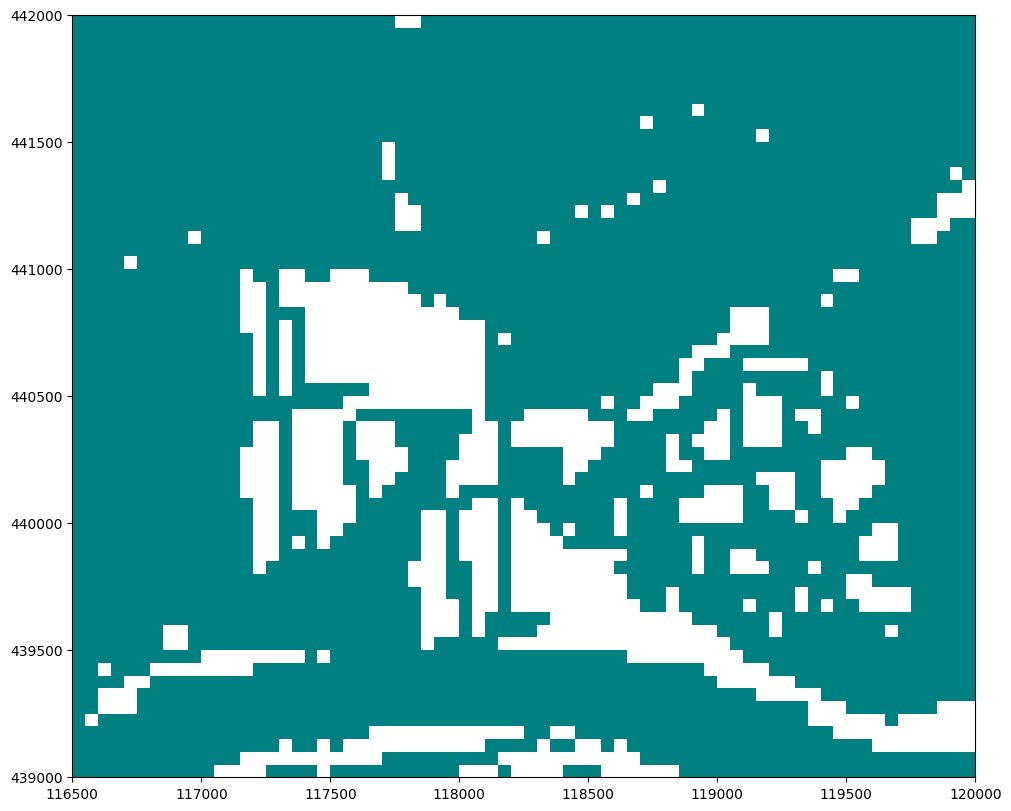

In [30]:
# use flopy plotting methods
fig, ax = plt.subplots(1, 1, figsize=(10, 8), constrained_layout=True)
mv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
mv.plot_bc("RIV")

## Write + run model

Now write the model simulation to disk, and run the simulation.

In [31]:
nlmod.sim.write_and_run(sim, ds, write_ds=True, script_path="02_surface_water.ipynb")

INFO:nlmod.sim.sim.write_and_run:write script 2023082802_surface_water.ipynb to model workspace
INFO:nlmod.sim.sim.write_and_run:write model dataset to cache
INFO:nlmod.sim.sim.write_and_run:write modflow files to model workspace
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model steady...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 3429 based on size of stress_period_data
INFO:nlmod.sim.sim.write_and_run:run model
FloPy is using the following executable to run the model: ..\..\..\nlmod\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 02 2022 15:29:04 with Intel

## Visualize results

To see whether our surface water was correctly added to the model, let's visualize the results. We'll load the calculated heads, and plot them.

In [32]:
head = nlmod.gwf.get_heads_da(ds)

Plot the heads in a specific model layer

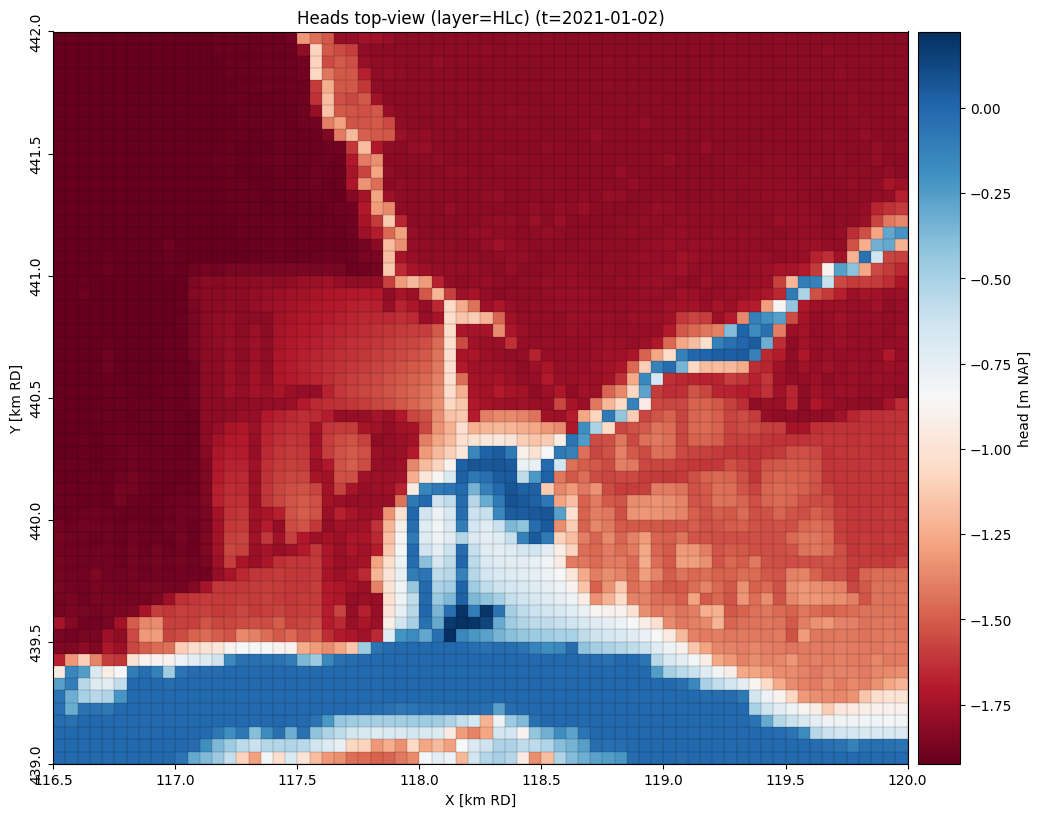

In [33]:
# using nlmod plotting methods
ax = nlmod.plot.map_array(
    head,
    ds,
    ilay=0,
    iper=0,
    plot_grid=True,
    title="Heads top-view",
    cmap="RdBu",
    colorbar_label="head [m NAP]",
)

In cross-section

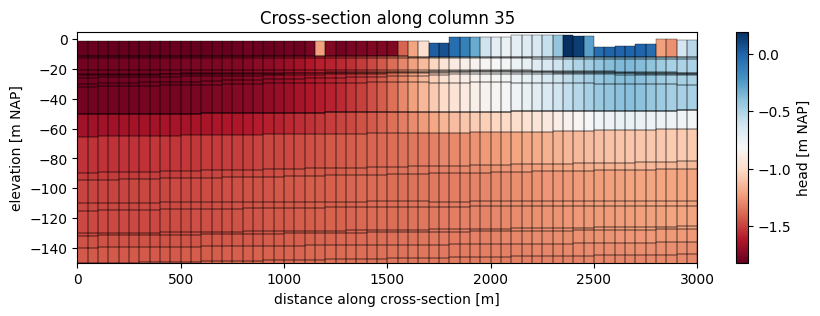

In [34]:
# using flopy plotting methods
col = gwf.modelgrid.ncol // 2

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax, line={"column": col})
qm = xs.plot_array(head[-1], cmap="RdBu")  # last timestep
xs.plot_ibound()  # plot inactive cells in red
xs.plot_grid(lw=0.25, color="k")
ax.set_ylim(bottom=-150)
ax.set_ylabel("elevation [m NAP]")
ax.set_xlabel("distance along cross-section [m]")
ax.set_title(f"Cross-section along column {col}")
cbar = fig.colorbar(qm, shrink=1.0)
cbar.set_label("head [m NAP]")